<a href="https://colab.research.google.com/github/pablo-arantes/ParametrizANI/blob/main/ParametrizANI_TorchANI%2BPsi4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ParametrizANI: Fast, Accurate and Free Parametrization for Small Molecules**

This Jupyter notebook provides a protocol to compute a reference dihedral potential using Psi4 and TorchANI for structural optimization.
TorchANI is a PyTorch-based library for training and inference of ANI (ANAKIN-ME) deep learning models, which are designed to generate accurate potential energy surfaces and predict physical properties of molecular systems.

TorchANI is open-source and freely available on GitHub:
👉 https://github.com/aiqm/torchani

The main goal of this notebook is to demonstrate how to harness the power of cloud-computing to parametrize compounds in a cheap and yet feasible fashion.

---

 **This notebook is NOT a standard protocol for parametrization!** It is just simple parametrization pipeline illustrating each step of a protocol.

---
**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/pablo-arantes/ParametrizANI/issues

**Acknowledgments**

- We would like to express our gratitude to the team behind [Rotational Profiler](https://rotprof.lncc.br/index.php), especially [Victor H. Rusu](https://www.linkedin.com/in/victor-holanda-rusu-463766b2/) and [Roberto D. Lins](https://www.linkedin.com/in/roberto-lins-49477710/), for their dedication in developing the code and making it permanently available to the community.

- We would like to thank the OpenMM team for developing an excellent and open source engine.

- We would like to thank the [Psi4](https://psicode.org/) team for developing an excellent and open source suite of ab initio quantum chemistry.

- We would like to thank the [Roitberg](https://roitberg.chem.ufl.edu/) team for developing the fantastic [TorchANI](https://github.com/aiqm/torchani).

- We would like to thank the [Olexandr Isayev](https://twitter.com/olexandr) team for developing the fantastic [AIMNet2](https://github.com/isayevlab/AIMNet2).

- We would like to thank the [Xavier Barril](http://www.ub.edu/bl/) team for their protocol on dihedrals parametrization.

- We would like to thank [iwatobipen](https://twitter.com/iwatobipen) for his fantastic [blog](https://iwatobipen.wordpress.com/) on chemoinformatics.

- Also, credit to [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin.

- Finally, we would like to thank [Making it rain](https://github.com/pablo-arantes/making-it-rain) team, **Pablo R. Arantes** ([@pablitoarantes](https://twitter.com/pablitoarantes)), **Marcelo D. Polêto** ([@mdpoleto](https://twitter.com/mdpoleto)), **Conrado Pedebos** ([@ConradoPedebos](https://twitter.com/ConradoPedebos)) and **Rodrigo Ligabue-Braun** ([@ligabue_braun](https://twitter.com/ligabue_braun)), for their amazing work.


- For related notebooks see: https://github.com/pablo-arantes/ParametrizANI

# **Workflow for dihedral parametrization:**

An end-to-end pipeline integrating neural network potentials and molecular mechanics:

The workflow starts from a SMILES string and proceeds through the following steps:
1.	**Conformer generation**;
2.	**Geometry optimization** with TorchANI;
3.	**Reference energy calculations** using Psi4;
4.	**Energy minimization** with OpenMM;
5.	**Dihedral parameter optimizatio**n via least-squares fitting to reproduce the reference energy profile;
6.	**Validation**, and,
7.	**Generation of final topology and parameter** files for use in molecular simulations.

<img src="https://github.com/pablo-arantes/ParametrizANI//raw/main/flux.png" width="400" height="HEIGHT">

# **Setting the environment for the calculation**

Firstly, we need to install all necessary libraries and packages for our protocol. The main packages we will be installing are:

1.    Anaconda (https://docs.conda.io/en/latest/miniconda.html)
2.    Psi4 (https://psicode.org/)
3.    RDKit (https://www.rdkit.org/)
4.    py3Dmol (https://pypi.org/project/py3Dmol/)
5.    Numpy (https://numpy.org/)
6.    Matplotlib (https://matplotlib.org/)
7.    TorchANI (https://aiqm.github.io/torchani/)

In [ ]:
#@title **Install Conda Colab**
#@markdown It will restart the kernel (session), don't worry.
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [ ]:
#@title **Install dependencies**
#@markdown It will take a few minutes, please, drink a coffee and wait. ;-)
# install dependencies
import subprocess
import sys
subprocess.run("rm -rf /usr/local/conda-meta/pinned", shell=True)
subprocess.run("mamba create -n psi4_env psi4 -c conda-forge/label/psi4_dev", shell=True)
subprocess.run("pip -q install py3Dmol", shell=True)
subprocess.run("pip install torchani", shell=True)
subprocess.run("pip install ase", shell=True)
subprocess.run("mamba install openmm", shell=True)
subprocess.run("mamba install openmmforcefields -c conda-forge -y", shell=True)
subprocess.run("mamba install -c conda-forge openbabel -y", shell=True)
subprocess.run("mamba install -c conda-forge pymol-open-source -y", shell=True)

CompletedProcess(args='mamba install -c conda-forge pymol-open-source -y', returncode=0)

Smiles: C1=CC=C(C=C1)/C=C/C(=O)C2=CC=CC=C2


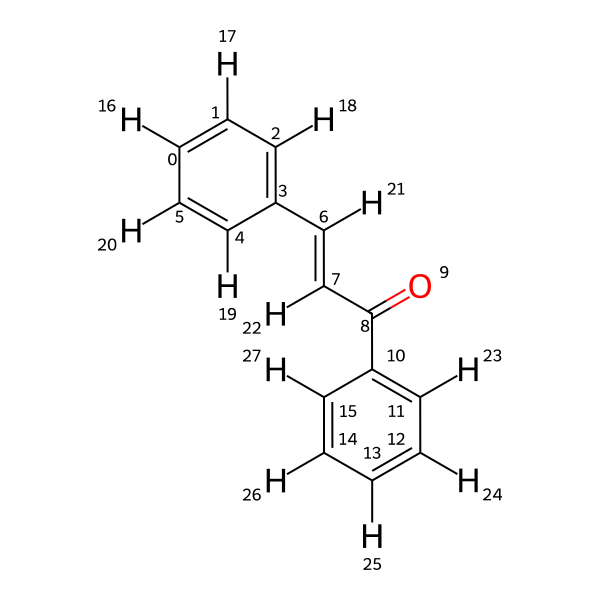

In [ ]:
#@title **Please Provide the Required Information for Your Molecule**

#@markdown Enter the SMILES string or filename of your molecule (supported formats: PDB or MOL).
#@markdown **Examples:** `C=CC(=O)OC`, `molecule.pdb`, or `molecule.mol`.

#@markdown If you want to use a PDB or MOL file, please make sure to upload the file to this Colab session first.

#@markdown If you are unsure of the exact SMILES notation, you can search for it at [PubChem](https://pubchem.ncbi.nlm.nih.gov/).

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolTransforms
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
from IPython.display import SVG
import ipywidgets as widgets
import rdkit
from rdkit.Chem.Draw import IPythonConsole
AllChem.SetPreferCoordGen(True)
from IPython.display import Image
from openbabel import pybel
import os

def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

import py3Dmol


workDir = "/content/"
Type = "smiles" #@param ["smiles", "pdb", "mol"]

smiles_or_filename = 'C1=CC=C(C=C1)/C=C/C(=O)C2=CC=CC=C2' #@param {type:"string"}

if Type == "smiles":
  Smiles = smiles_or_filename
  smiles_fig = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(smiles_fig)
elif Type == "pdb":
  mol= [m for m in pybel.readfile(filename=smiles_or_filename, format='pdb')][0]
  out=pybel.Outputfile(filename='mol.mol',format='mol',overwrite=True)
  out.write(mol)
  out.close()
  mol = Chem.MolFromMolFile('mol.mol')
  Smiles = Chem.MolToSmiles(mol)
  smiles_fig = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(smiles_fig)
else:
  mol = Chem.MolFromMolFile(smiles_or_filename)
  Smiles = Chem.MolToSmiles(mol)
  smiles_fig = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(smiles_fig)


d2d = rdMolDraw2D.MolDraw2DSVG(600, 600)
d2d.drawOptions().addAtomIndices=True
d2d.DrawMolecule(hmol)
d2d.FinishDrawing()
svg = d2d.GetDrawingText()
with open('smiles.svg', 'w') as f:
    f.write(svg)
print("Smiles: " + str(Smiles))
SVG(svg)

In [ ]:
#@title ### **Set Your Dihedral Angle**
#@markdown Specify the indices of the four atoms that define the dihedral angle to be parametrized.

#@markdown The selected atoms will be used to calculate and fit the dihedral energy profile.

#@markdown The order of the atoms should follow: atom1 - atom2 - atom3 - atom4, where atom2–atom3 is the rotatable bond.

#@markdown 📌 *Example:* `[2, 5, 6, 8]` means you are analyzing the dihedral defined by atoms 2-5-6-8.


from termcolor import colored

atom1 = '7' #@param {type:"string"}
atom2 = '8' #@param {type:"string"}
atom3 = '10' #@param {type:"string"}
atom4 = '11' #@param {type:"string"}

#@markdown Select the step size (in degrees) for rotating the dihedral angle during the energy scan.
#@markdown A smaller step size provides higher resolution but increases computational cost.


degrees_steps = "30" #@param ["10", "15", "20", "30", "45", "60"]
with open('degrees.dat', 'w') as f:
  f.write(degrees_steps)

optimization = "MMFF94" #@param ["ANI", "MMFF94"]

if optimization == "MMFF94":
  mol = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(mol)
  AllChem.EmbedMolecule(hmol)
  mp = AllChem.MMFFGetMoleculeProperties(hmol)
  ff = AllChem.MMFFGetMoleculeForceField(hmol, mp)
  AllChem.OptimizeMolecule(ff, maxIters=1000)
  ff.Minimize()
  charge_mol = Chem.rdPartialCharges.ComputeGasteigerCharges(hmol)
  charge = Chem.GetFormalCharge(hmol)
  AllChem.MolToMolFile(hmol, (os.path.join(workDir, f"start_min.mol")))

  print("Charge = " + str(charge))
  if not charge == 0:
    print(colored("ANI cannot do charged system yet, stay tuned!", 'red'))
    exit()
  else:
    pass
  mol_end = mol_with_atom_index(hmol)
  IPythonConsole.drawMol3D(hmol)
else:
  from typing import List
  from ase import Atoms
  from ase.lattice.cubic import Diamond
  from ase.md.langevin import Langevin
  from ase.optimize import BFGS
  from ase import io
  from ase.io import read, write
  from ase import units
  from ase.constraints import ExternalForce, FixInternals
  import torch
  import torchani
  import pandas as pd
  import numpy as np
  from torchani.units import HARTREE_TO_KCALMOL
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  model = torchani.models.ANI2x(periodic_table_index=True).to(device)
  calculator = torchani.models.ANI2x().ase()
  print("Model = ANI2x")


  def mol2arr(mols, device=device):
      coordinates = []
      spices = []
      for mol in mols:
          pos = mol.GetConformer().GetPositions().tolist()
          atomnums = [a.GetAtomicNum() for a in mol.GetAtoms()]
          coordinates.append(pos)
          spices.append(atomnums)
      coordinates = torch.tensor(coordinates, requires_grad=True, device=device)
      species = torch.tensor(spices, device=device)
      return coordinates, species

  mol = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(mol)
  AllChem.EmbedMolecule(hmol)
  mp = AllChem.MMFFGetMoleculeProperties(hmol)
  ff = AllChem.MMFFGetMoleculeForceField(hmol, mp)
  AllChem.OptimizeMolecule(ff, maxIters=1000)
  ff.Minimize()
  charge_mol = Chem.rdPartialCharges.ComputeGasteigerCharges(hmol)
  charge = Chem.GetFormalCharge(hmol)
  print("Charge = " + str(charge))
  if not charge == 0:
    print(colored("ANI cannot do charged system yet, stay tuned!", 'red'))
    exit()
  else:
    pass
  AllChem.MolToMolFile(hmol, (os.path.join(workDir, f"start.mol")))
  mol_deg = AllChem.MolFromMolFile ((os.path.join(workDir, f"start.mol")), removeHs=False)
  mol = io.read(os.path.join(workDir, f"start.mol"))
  coordinates, species = mol2arr([mol_deg], device)
  tensor1 = coordinates.detach().numpy()
  atoms = Atoms(mol, positions=tensor1[0])
  atoms.center(vacuum=3.0)
  atoms.set_calculator(calculator)
  print("Begin minimizing ")
  opt = BFGS(atoms)
  opt.run(fmax=0.0001)
  write((os.path.join(workDir, f"start_min.xyz")), format="xyz", images=atoms)

  atomic_symbols = []
  xyz_coordinates = []

  with open((os.path.join(workDir, f"start_min.xyz")), "r") as file:
    for line_number,line in enumerate(file):
      if line_number == 0:
        num_atoms = int(line)
      elif line_number == 1:
        comment = line # might have useful information
      else:
        atomic_symbol, x, y, z = line.split()
        atomic_symbols.append(atomic_symbol)
        xyz_coordinates.append([float(x),float(y),float(z)])

  from rdkit.Geometry import Point3D
  conf = mol_deg.GetConformer()

  for i in range(mol_deg.GetNumAtoms()):
    x,y,z = xyz_coordinates[i]
    conf.SetAtomPosition(i,Point3D(x,y,z))
  AllChem.MolToMolFile(mol_deg, (os.path.join(workDir, f"start_min.mol")))


  hmol = AllChem.MolFromMolFile ((os.path.join(workDir, f"start_min.mol")), removeHs=False)
  mol_end = mol_with_atom_index(hmol)
  IPythonConsole.drawMol3D(hmol)

Charge = 0


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
#@title ### **Generate Conformers Based on the Selected Dihedral Angle**
#@markdown Run this cell to generate conformers by rotating the selected dihedral angle.
#@markdown The dihedral will be systematically rotated from -180° to 180°, using the step size defined in the previous cell.

#Create the conformers and save in the folder
import glob
import copy
import numpy as np
from IPython.display import display
from openbabel import openbabel

def convert_mol_to_xyz(mol_file_path, xyz_file_path):
    obConversion = openbabel.OBConversion()
    obConversion.SetInAndOutFormats("mol", "xyz")

    mol = openbabel.OBMol()
    obConversion.ReadFile(mol, mol_file_path)
    obConversion.WriteFile(mol, xyz_file_path)

if os.path.exists(os.path.join(workDir, "mol_files")):
  for f in glob.glob(os.path.join(workDir, "mol_files/*.mol")):
    os.remove(f)
else:
  os.mkdir(os.path.join(workDir, "mol_files"))

confs = []
filenames = []

if optimization == "ANI":
  hmol = AllChem.MolFromMolFile ((os.path.join(workDir, f"start_min.mol")), removeHs=False)
else:
  pass

for deg in range(-180, (180+int(degrees_steps)), int(degrees_steps)):
    rdMolTransforms.SetDihedralDeg(hmol.GetConformer(0), int(atom1), int(atom2), int(atom3), int(atom4), deg)
    mp = AllChem.MMFFGetMoleculeProperties(hmol)
    new_match = hmol.GetSubstructMatch(hmol)
    ff = AllChem.MMFFGetMoleculeForceField(hmol, mp)
    ff.MMFFAddTorsionConstraint(int(atom1), int(atom2), int(atom3), int(atom4), False, deg, deg, 1000.0,)
    # for a in hmol.GetAtoms():
    #     if (a.GetAtomicNum() > 1):
    #         ff.MMFFAddPositionConstraint(a.GetIdx(), 0.0, 1.e4)
    # AllChem.OptimizeMolecule(ff, maxIters=200)
    # ff.Minimize(maxIts=1000)
    for atidx in new_match:
      ff.MMFFAddPositionConstraint(atidx,0.05,200)
    maxIters = 10
    while ff.Minimize(maxIts=1000) and maxIters>0:
      maxIters -=1
    AllChem.MolToMolFile(hmol, (os.path.join(workDir, "mol_files/" + str(deg) + ".mol")))
    if deg % 90 == 0:
        print(deg)
        display(IPythonConsole.drawMol3D(hmol))
    mol_file_path = os.path.join(workDir, "mol_files/" + str(deg) + ".mol")  # Replace with your MOL file path
    xyz_file_path = os.path.join(workDir, "mol_files/" + str(deg) + ".xyz")
    convert_mol_to_xyz(mol_file_path, xyz_file_path)

-180


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

None

-90


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

None

0


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

None

90


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

None

180


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

None

In [ ]:
#@title **Geometry optimization of conformers with TorchANI**:

#@markdown Optimization of each conformer, using **TorchANI** as the optimizing engine.

#@markdown ANI is a general-purpose neural network-based atomistic potential for organic molecules. Four ANI models have been published, the ANI-1, ANI-1x, ANI-1ccx, and ANI-2x potentials. The ANI-1 model was developed by random sampling conformational space of 57k organic molecules with up to eight heavy atoms, C, N, and O, plus H atoms to have proper chemistry, then running DFT calculations to obtain potential energies for training. ANI-1x was trained to a data set of molecular conformations sampled through an active learning scheme. Active learning is where the model itself is iteratively used to decide what new data should be included in the next iteration. ANI-1ccx was trained to the ANI-1x data set, then retrained to a 10% smaller data set of accurate coupled cluster calculations, resulting in a potential that outperformed DFT in test cases. ANI-2x was trained by adding many millions of data points to the ANI-1x data set, at the same level of theory, but including elements S, F, and Cl. We included the **ANI-1x**, **ANI-1ccx**, and **ANI-2x** models in our notebook.

#@markdown If you want to know more about **TorchANI**, please, check at https://aiqm.github.io/torchani/

#@markdown Please, select your ANI model:
model_name = "ANI-2x" #@param ["ANI-1x", "ANI-1ccx", "ANI-2x"]

#@markdown Convergence threshold for geometry optimization:

opt_tol = 0.0001 #@param {type:"slider", min:0.0001, max:0.01, step:0.0001}

from typing import List
from ase import Atoms
from ase.lattice.cubic import Diamond
from ase.md.langevin import Langevin
from ase.optimize import LBFGS
from ase import io
from ase.io import read, write
from ase import units
from ase.constraints import ExternalForce, FixInternals
from ase.calculators.psi4 import Psi4
from ase.build import molecule
import torch
import torchani
import pandas as pd
import numpy as np
from torchani.units import HARTREE_TO_KCALMOL
from openbabel import openbabel

def convert_mol_to_xyz(mol_file_path, xyz_file_path):
    obConversion = openbabel.OBConversion()
    obConversion.SetInAndOutFormats("mol", "xyz")

    mol = openbabel.OBMol()
    obConversion.ReadFile(mol, mol_file_path)
    obConversion.WriteFile(mol, xyz_file_path)



# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

if model_name == "ANI-2x":
  model = torchani.models.ANI2x(periodic_table_index=True).to(device)
  calculator = torchani.models.ANI2x().ase()
  print("Model = ANI2x")
elif model_name == "ANI-1ccx":
  model = torchani.models.ANI1ccx(periodic_table_index=True).to(device)
  calculator = torchani.models.ANI1ccx().ase()
  print("Model = ANI1ccx")
elif model_name == "ANI-1x":
  model = torchani.models.ANI1x(periodic_table_index=True).to(device)
  calculator = torchani.models.ANI1x().ase()
  print("Model = ANI1x")
else:
  pass

def mol2arr(mols, device=device):
    coordinates = []
    spices = []
    for mol in mols:
        pos = mol.GetConformer().GetPositions().tolist()
        atomnums = [a.GetAtomicNum() for a in mol.GetAtoms()]
        coordinates.append(pos)
        spices.append(atomnums)
    coordinates = torch.tensor(coordinates,
                               requires_grad=True,
                               device=device)
    species = torch.tensor(spices, device=device)
    return coordinates, species


for deg in range(-180, (180+int(degrees_steps)), int(degrees_steps)):
  mol_deg = AllChem.MolFromMolFile ((os.path.join(workDir, "mol_files/" + str(deg) + ".mol")), removeHs=False)
  mol = io.read(os.path.join(workDir, "mol_files/" + str(deg) + ".mol"))
  coordinates, species = mol2arr([mol_deg], device)
  tensor1 = coordinates.detach().numpy()
  atoms = Atoms(mol, positions=tensor1[0])
  atoms.center(vacuum=3.0)
  dihedral_indices1 = [int(atom1), int(atom2), int(atom3), int(atom4)]
  dihedral1 = [atoms.get_dihedral(*dihedral_indices1), dihedral_indices1]
  c = FixInternals(dihedrals_deg=[dihedral1])
  atoms.set_constraint(c)
  atoms.set_calculator(calculator)
  print("Begin minimizing " + str(deg) + ".mol" )
  opt = LBFGS(atoms)
  opt.run(fmax=opt_tol)
  write((os.path.join(workDir, "mol_files/" + str(deg) + "_min.xyz")), format="xyz", images=atoms)

  atomic_symbols = []
  xyz_coordinates = []

  with open((os.path.join(workDir, "mol_files/" + str(deg) + "_min.xyz")), "r") as file:
    for line_number,line in enumerate(file):
        if line_number == 0:
            num_atoms = int(line)
        elif line_number == 1:
            comment = line # might have useful information
        else:
            atomic_symbol, x, y, z = line.split()
            atomic_symbols.append(atomic_symbol)
            xyz_coordinates.append([float(x),float(y),float(z)])

  from rdkit.Geometry import Point3D
  conf = mol_deg.GetConformer()

  for i in range(mol_deg.GetNumAtoms()):
    x,y,z = xyz_coordinates[i]
    conf.SetAtomPosition(i,Point3D(x,y,z))
  AllChem.MolToMolFile(mol_deg, (os.path.join(workDir, "mol_files/" + str(deg) + "_min.mol")))
  AllChem.MolToPDBFile(mol_deg, (os.path.join(workDir, "mol_files/" + str(deg) + "_min.pdb")))
  mol_file_path = os.path.join(workDir, "mol_files/" + str(deg) + "_min.mol")  # Replace with your MOL file path
  xyz_file_path = os.path.join(workDir, "mol_files/" + str(deg) + ".xyz")
  convert_mol_to_xyz(mol_file_path, xyz_file_path)

/usr/local/lib/python3.11/site-packages/torchani/resources/
/usr/local/lib/python3.11/site-packages/torchani/resources/
Model = ANI2x
Begin minimizing -180.mol
       Step     Time          Energy          fmax
LBFGS:    0 13:48:18   -17792.252872        0.705228
LBFGS:    1 13:48:18   -17792.267495        0.649876
LBFGS:    2 13:48:18   -17792.277036        0.239546
LBFGS:    3 13:48:18   -17792.282627        0.210483
LBFGS:    4 13:48:18   -17792.287579        0.261222
LBFGS:    5 13:48:18   -17792.291622        0.152538
LBFGS:    6 13:48:18   -17792.295661        0.157027
LBFGS:    7 13:48:18   -17792.298748        0.122051
LBFGS:    8 13:48:18   -17792.300616        0.114389
LBFGS:    9 13:48:18   -17792.302797        0.107149
LBFGS:   10 13:48:18   -17792.305987        0.169186
LBFGS:   11 13:48:18   -17792.309575        0.179774
LBFGS:   12 13:48:18   -17792.313846        0.142088
LBFGS:   13 13:48:19   -17792.318659        0.149130
LBFGS:   14 13:48:19   -17792.322861        0.1

In [ ]:
#@title **Dihedral scan energy profile with Psi4**:

%%bash
source activate psi4_env
python
import psi4
import os
import sys
import numpy as np
import multiprocessing

cores = multiprocessing.cpu_count() # Count the number of cores in a computer

workDir = "/content/"

#@markdown **Specify the Dihedral Atoms:**

#@markdown Provide the indices of the four atoms that define the dihedral angle of interest.

#@markdown This dihedral will be scanned to generate the energy profile.

#@markdown The order of the atoms should follow: atom1 - atom2 - atom3 - atom4, where atom2–atom3 is the rotatable bond.

#@markdown 📌 *Example:* `[2, 5, 6, 8]` means you are analyzing the dihedral defined by atoms 2-5-6-8.

atom1 = '7' #@param {type:"string"}
atom2 = '8' #@param {type:"string"}
atom3 = '10' #@param {type:"string"}
atom4 = '11' #@param {type:"string"}

#@markdown Select the step size (in degrees) for rotating the dihedral angle during the energy scan.
#@markdown A smaller step size provides higher resolution but increases computational cost.

degrees_steps = "30" #@param ["10", "15", "20", "30", "45", "60"]

#@markdown Please, select your method and basis set:

method = "HF" #@param ["B3LYP", "MP2", "HF"]
#@markdown Quantum chemistry method used to calculate the molecular electrostatic potential.

#@markdown - **HF (Hartree-Fock)**: a fast, basic wavefunction method.

#@markdown - **B3LYP**: a popular hybrid Density Functional Theory (DFT) method, more accurate.

#@markdown - **MP2**: a post-Hartree-Fock method including electron correlation, usually more accurate but computationally expensive.

basisSet = "6-31G*" #@param ["STO-3g", "3-21G", "6-31G*", "6-31G**", "6-31+G(d,p)", "6-311++G(2d,p)"]
#@markdown The set of functions used to describe atomic orbitals in the quantum calculation.

#@markdown Larger and more complex basis sets (like 6-311++G(2d,p)) typically give more accurate results but require more computational resources.

#@markdown The "star" (*) and plus (+) symbols indicate addition of polarization and diffuse functions, improving flexibility for electrons.

geometry_optimization = "No" #@param ["Yes", "No"]
#@markdown Defines the type of quantum chemistry calculation:

#@markdown - **Single Point**: Calculates energy and properties at a fixed geometry (no structure change).

#@markdown - **Geometry Optimization**: Iteratively adjusts the molecular geometry to find the lowest energy structure before calculating properties.

#@markdown **Maximum Number of Geometry Optimization Steps:**

#@markdown Defines the maximum number of iterations allowed during the geometry optimization process.
#@markdown Increasing this value allows more time for convergence, but also increases computational cost.

#@markdown Typical values range from 100 to 500 for small molecules.

geom_maxiter = 50 #@param {type:"slider", min:50, max:1000, step:50}

def B3LYP_basis (basis_Set):
    vals = {"STO-3g" : "STO-3g"  ,  "3-21G" : "3-21G", "6-31G*" : "6-31g*", "6-31G**" : "6-31g**", "6-31+G(d,p)" : "6-31+G(d,p)", "6-311++G(2d,p)" : "6-311++G(2d,p)" }
    return vals[basis_Set]

def MP2_basis (basis_Set):
    vals = {"STO-3g" : "STO-3g"  ,  "3-21G" : "3-21G", "6-31G*" : "6-31g*", "6-31G**" : "6-31g**", "6-31+G(d,p)" : "6-31+G(d,p)", "6-311++G(2d,p)" : "6-311++G(2d,p)" }
    return vals[basis_Set]

def HF_basis (basis_Set):
    vals = {"STO-3g" : "STO-3g"  ,  "3-21G" : "3-21G", "6-31G*" : "6-31g*", "6-31G**" : "6-31g**", "6-31+G(d,p)" : "6-31+G(d,p)", "6-311++G(2d,p)" : "6-311++G(2d,p)" }
    return vals[basis_Set]

if method == "B3LYP":
  basis_set_psi4 = B3LYP_basis(basisSet)
elif method == "MP2":
  basis_set_psi4 = MP2_basis(basisSet)
elif method == "HF":
  basis_set_psi4 = HF_basis(basisSet)
else:
  pass

atm1 = int(atom1) + 1
atm2 = int(atom2) + 1
atm3 = int(atom3) + 1
atm4 = int(atom4) + 1
dihedral_string = str(atm1) + " " + str(atm2) + " " + str(atm3) + " " + str(atm4)


dihedral_energies = []
dihe_degree = []

for deg in range(-180, (180+int(degrees_steps)), int(degrees_steps)):

  xyz_file_path = os.path.join(workDir, "mol_files/" + str(deg) + "_min.xyz")

  # Setting memory and output file
  psi4.set_memory('12 GB')
  psi4.set_num_threads(cores)
  psi4.core.set_output_file(os.path.join(workDir, "mol_files/" + str(deg) + ".dat"), False)

  # Read the XYZ file
  xyz_data = open(xyz_file_path).read()

  # Create Psi4 molecule
  mol = psi4.geometry(xyz_data)

  if geometry_optimization == "Yes":

    # Setting optimization parameters
    psi4.set_options({
      'frozen_dihedral': dihedral_string,
      'basis': basis_set_psi4,
      'scf_type': 'df',
      'g_convergence': 'gau',
      'geom_maxiter': geom_maxiter
    })

    # Geometry optimization
    e = psi4.optimize(method)

    # Save optimized geometry of each degree
    mol.save_xyz_file(os.path.join(workDir, "mol_files/" + str(deg) + "_optimized.xyz"), False)
  else:
    # Single-point energy calculation
    psi4.set_options({
      'basis': basis_set_psi4,
      'guess': 'sad',
      'scf_type': 'df'
    })

    e = psi4.energy(method)

  econv = e * psi4.constants.hartree2kcalmol
  dihedral_energies.append(econv)
  dihe_degree.append(deg)

  print(f"E [kcal/mol]: {econv:10.6f}\n")

dihedral_energies_array = np.array(dihedral_energies)
relative = (dihedral_energies_array - dihedral_energies_array.min())

#Save dat file of QM data to plot further
with open('qm.dat', 'w') as f:
    for deg, item in zip(dihe_degree, relative):
      degree_str = str("{:.3f}".format(deg))
      energy_str = str("{:.3f}".format(item))
      # print(str(deg) + " " + str(item) + "\n")
      f.write("%s\n" % item)


  Memory set to  11.176 GiB by Python driver.
  Threads set to 2 by Python driver.
E [kcal/mol]: -407799.557052

E [kcal/mol]: -407799.608795

E [kcal/mol]: -407797.185424

E [kcal/mol]: -407794.990568

E [kcal/mol]: -407797.243586

E [kcal/mol]: -407799.643494

E [kcal/mol]: -407799.556931

E [kcal/mol]: -407799.643593

E [kcal/mol]: -407797.243668

E [kcal/mol]: -407794.990421

E [kcal/mol]: -407797.184885

E [kcal/mol]: -407799.609097

E [kcal/mol]: -407799.556963



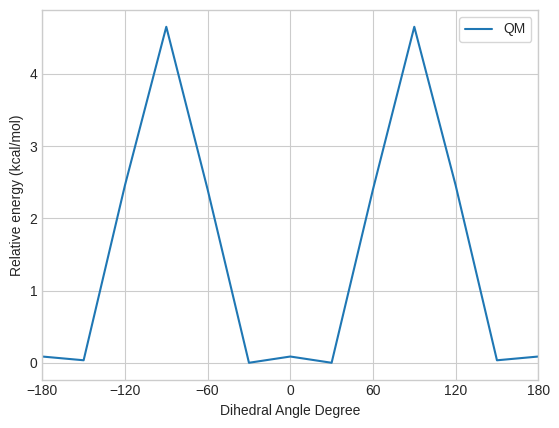

In [ ]:
#@title **Visualize the Dihedral Energy Profile Calculated with Psi4**

#@markdown This plot shows the potential energy profile obtained from single point or geometry optimization calculations performed using Psi4.

#@markdown - **X-axis:** Dihedral angle in degrees (typically scanned from -180° to 180°).
#@markdown - **Y-axis:** Relative energy in kcal/mol with respect to the minimum energy conformation.

#@markdown This curve represents the reference quantum mechanical potential that will be used for fitting classical dihedral parameters.
import numpy as np
# Initialize an empty list to store the numbers
relative = []

# Open the file and read each line
with open('qm.dat', 'r') as file:
    for line in file:
        # Convert line to float and append to the list
        number_rela = float(line.strip())
        relative.append(number_rela)

dihe_degree = []
for deg in range(-180, (180+int(degrees_steps)), int(degrees_steps)):
  dihe_degree.append(deg)

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

plt.plot(dihe_degree, relative, linewidth = 1.5, label = "QM")

# ani = pd.read_csv('/content/ani.dat', header=None)
# plt.plot(dihe_degree, ani, linewidth = 1.5, label = "ANI")

plt.xticks(np.arange(min(dihe_degree), max(dihe_degree)+1, 60.0))
plt.xlim([-180, 180])
plt.legend(frameon=True)
plt.xlabel('Dihedral Angle Degree')
plt.ylabel('Relative energy (kcal/mol)')
plt.savefig('QM.png', dpi=600, bbox_inches='tight')

In [ ]:
#@title **OpenMM Minimization with Dihedral Potential Set to Zero**

#@markdown Choose how to handle the dihedral potential during energy minimization of the conformers:

#@markdown - **Set to 0**: Minimizes the conformers **excluding the dihedral energy term** (only for the selected dihedral). This option considers only Van der Waals and electrostatic interactions and is recommended when you want to **parametrize a new dihedral potential** from scratch.

#@markdown - **Set to Default**: Minimizes the conformers using the **original dihedral parameters** from the selected force field. Use this option to **evaluate how well the force field describes** the selected dihedral angle.

#@markdown **Parameters to change the molecule topology:**


Force_field = "openff-2.0.0" #@param ['gaff-1.4', 'gaff-1.8', 'gaff-1.81', 'gaff-2.1', 'gaff-2.11', 'smirnoff99Frosst-1.1.0', 'smirnoff99Frosst-1.0.0', 'smirnoff99Frosst-1.0.9', 'smirnoff99Frosst-1.0.1', 'smirnoff99Frosst-1.0.6', 'smirnoff99Frosst-1.0.5', 'smirnoff99Frosst-1.0.7', 'smirnoff99Frosst-1.0.8', 'smirnoff99Frosst-1.0.2', 'smirnoff99Frosst-1.0.4', 'smirnoff99Frosst-1.0.3', 'openff-1.0.0-RC1', 'openff-1.0.1', 'openff-1.3.1-alpha.1', 'openff-1.0.0', 'openff-1.2.0', 'openff-2.0.0-rc.2', 'openff-2.0.0-rc.1', 'openff-2.0.0', 'openff-1.1.0', 'openff-1.3.1', 'openff-1.1.1', 'openff-1.0.0-RC2', 'openff-1.3.0', 'openff-1.2.1']
Dihedral_potential_energy = "0" #@param ['0', 'Default']

#@markdown Force constant to restrain the dihedral angle:

Force_constant = 1000 #@param {type:"slider", min:100, max:2000, step:100}


#@markdown Convergence threshold for minimization energy:

opt_tol = 0.001 #@param {type:"slider", min:0.001, max:0.1, step:0.001}

import warnings
warnings.filterwarnings("ignore")
from mdtraj.geometry import dihedral
from openmm import app, unit
from openmm.app import HBonds, NoCutoff, PDBFile
# Imports from the toolkit
import openff.toolkit
from openff.toolkit.topology import Molecule, Topology
from openff.toolkit.typing.engines.smirnoff import ForceField
from openff.toolkit.utils import get_data_file_path
from simtk.openmm.app import PDBFile
from openmmforcefields.generators import SMIRNOFFTemplateGenerator
from openmmforcefields.generators import GAFFTemplateGenerator

import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *

from sys import stdout, exit, stderr
import os, math, fnmatch


workDir2 = "/content/"

if os.path.exists(os.path.join(workDir2, "potential_energy.txt")):
  for f in glob.glob(os.path.join(workDir2, "pdb_min/*.pdb")):
    os.remove(f)
  os.remove(os.path.join(workDir2,"potential_energy.txt"))
else:
  if os.path.exists(os.path.join(workDir2, "pdb_min")):
    for f in glob.glob(os.path.join(workDir2, "pdb_min/*.pdb")):
      os.remove(f)
    os.rmdir(os.path.join(workDir2, "pdb_min"))
    os.mkdir(os.path.join(workDir2, "pdb_min"))
  else:
    os.mkdir(os.path.join(workDir2, "pdb_min"))


# Create an OpenFF Molecule object for benzene from sdf
from openff.toolkit.topology import Molecule
molecule = Molecule.from_smiles(Smiles)
# molecule = Molecule.from_file("/content/mol_files/0_min.mol")

small_ff_options = ['gaff-1.4', 'gaff-1.8', 'gaff-1.81', 'gaff-2.1', 'gaff-2.11', 'smirnoff99Frosst-1.1.0', 'smirnoff99Frosst-1.0.0', 'smirnoff99Frosst-1.0.9', 'smirnoff99Frosst-1.0.1',
            'smirnoff99Frosst-1.0.6', 'smirnoff99Frosst-1.0.5', 'smirnoff99Frosst-1.0.7', 'smirnoff99Frosst-1.0.8', 'smirnoff99Frosst-1.0.2', 'smirnoff99Frosst-1.0.4',
            'smirnoff99Frosst-1.0.3', 'openff-1.0.0-RC1', 'openff-1.0.1', 'openff-1.3.1-alpha.1', 'openff-1.0.0', 'openff-1.2.0', 'openff-2.0.0-rc.2', 'openff-2.0.0-rc.1',
            'openff-2.0.0', 'openff-1.1.0', 'openff-1.3.1', 'openff-1.1.1', 'openff-1.0.0-RC2', 'openff-1.3.0', 'openff-1.2.1']

type_generator_options = ('GAFF', 'GAFF', 'GAFF', 'GAFF', 'GAFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF',
                          'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF')

small_ff_include = ["'gaff-1.4'", "'gaff-1.8'", "'gaff-1.81'", "'gaff-2.1'", "'gaff-2.11'", "'smirnoff99Frosst-1.1.0'", "'smirnoff99Frosst-1.0.0'", "'smirnoff99Frosst-1.0.9'", "'smirnoff99Frosst-1.0.1'",
            "'smirnoff99Frosst-1.0.6'", "'smirnoff99Frosst-1.0.5'", "'smirnoff99Frosst-1.0.7'", "'smirnoff99Frosst-1.0.8'", "'smirnoff99Frosst-1.0.2'", "'smirnoff99Frosst-1.0.4'",
            "'smirnoff99Frosst-1.0.3'", "'openff-1.0.0-RC1'", "'openff-1.0.1'", "'openff-1.3.1-alpha.1'", "'openff-1.0.0'", "'openff-1.2.0'", "'openff-2.0.0-rc.2'", "'openff-2.0.0-rc.1'",
            "'openff-2.0.0'", "'openff-1.1.0'", "'openff-1.3.1'", "'openff-1.1.1'", "'openff-1.0.0-RC2'", "'openff-1.3.0'", "'openff-1.2.1'"]


small_ff_id = small_ff_options.index(Force_field)
type_generator = type_generator_options[small_ff_id]
small_ff = small_ff_include[small_ff_id]

# Teach OpenMM about the ligand molecule and force field
ligand_generator = type_generator + "TemplateGenerator(forcefield=" + small_ff + ", molecules=[molecule])"
type_generator_options = eval(ligand_generator)


# Create an OpenMM ForceField object with AMBER ff14SB and TIP3P with compatible ions
from simtk.openmm.app import ForceField
forcefield = ForceField('amber99sb.xml')

# Register the  template generator
forcefield.registerTemplateGenerator(type_generator_options.generator)

potential_energy = []
dihe_degree = []
for deg in range(-180, (180+int(degrees_steps)), int(degrees_steps)):
  pdbfile = PDBFile(os.path.join(workDir, "mol_files/" + str(deg) + "_min.pdb"))
  system = forcefield.createSystem(pdbfile.topology, nonbondedCutoff=1*nanometer, constraints=HBonds)

  for i, f in enumerate(system.getForces()):
    f.setForceGroup(i)


  energy_expression = "k*(1-cos(periodicity*theta-theta0))"
  custom_torsion_force = CustomTorsionForce(energy_expression)
  custom_torsion_force.addGlobalParameter("k", int(Force_constant))
  custom_torsion_force.addGlobalParameter("periodicity", 1)
  custom_torsion_force.addGlobalParameter("theta0", math.radians(deg))
  custom_torsion_force.addTorsion(int(atom1), int(atom2), int(atom3), int(atom4))
  system.addForce(custom_torsion_force)

  integrator = LangevinIntegrator(300*kelvin, 1/picosecond, 0.002*picoseconds)
  simulation = Simulation(pdbfile.topology, system, integrator)
  simulation.context.setPositions(pdbfile.positions)

  if Dihedral_potential_energy == "0":
    dih = [f for f in system.getForces() if isinstance(f, PeriodicTorsionForce)][0]
    for i in range(dih.getNumTorsions()):
      particle1, particle2, particle3, particle4, periodicity, phase, k = dih.getTorsionParameters(i)
      if particle2 == int(atom2) and particle3 == int(atom3):
        # print(dih.getTorsionParameters(i))
        dih.setTorsionParameters(i, particle1, particle2, particle3, particle4, 1, 0, 0)
        dih.updateParametersInContext(simulation.context)
        # print(dih.getTorsionParameters(i))
      elif particle2 == int(atom3) and particle3 == int(atom2):
        # print(dih.getTorsionParameters(i))
        dih.setTorsionParameters(i, particle1, particle2, particle3, particle4, 1, 0, 0)
        dih.updateParametersInContext(simulation.context)
        # print(dih.getTorsionParameters(i))
      else:
        pass
  else:
    pass

  simulation.minimizeEnergy(tolerance=float(opt_tol)*kilojoule/(mole*nanometer), maxIterations=int(1000000))
  minpositions = simulation.context.getState(getPositions=True).getPositions()
  app.PDBFile.writeFile(pdbfile.topology, minpositions, open(os.path.join(workDir2, "pdb_min/" + str(deg) + '_min.pdb'), 'w'))

  energy_kcal =  (simulation.context.getState(getEnergy=True).getPotentialEnergy())
  potential_energy.append(energy_kcal)
  dihe_degree.append(deg)
  for i, f in enumerate(system.getForces()):
    state = simulation.context.getState(getEnergy=True, groups={i})
    # print(f.getName(), state.getPotentialEnergy())
  # print(str(deg) + " =", str(energy_kcal))
  print("Running minimization for step:" + str(deg))
  print(str(energy_kcal), file=open("potential_energy.txt", "a",))

#Prepare the relative energy from MM
import pandas as pd
dataset = pd.read_csv('/content/potential_energy.txt', delimiter = " ", header=None)
df = pd.DataFrame(dataset)
df = df[df.columns[:1]]
new = df.to_numpy()
energy_diff = (np.array(new) - min(new)) * 0.239006
# print(np.round(energy_diff, 4))

print("Degrees    Energy")
#save a dat file
energy_mm = np.round(energy_diff, 4)
a_file = open("mm.dat", "w")
for deg, row in zip(dihe_degree, energy_mm):
    degree_str = str("{:.3f}".format(deg))
    energy_mm_str = str("{:.3f}".format(row[0]))
    string = degree_str.rjust(8, " ") + energy_mm_str.rjust(8, " ") + " kcal/mol"
    print(string)
    np.savetxt(a_file, row, fmt='%.6f')
a_file.close()

Running minimization for step:-180
Running minimization for step:-150
Running minimization for step:-120
Running minimization for step:-90
Running minimization for step:-60
Running minimization for step:-30
Running minimization for step:0
Running minimization for step:30
Running minimization for step:60
Running minimization for step:90
Running minimization for step:120
Running minimization for step:150
Running minimization for step:180
Degrees    Energy
-180.000   3.929 kcal/mol
-150.000   1.652 kcal/mol
-120.000   0.271 kcal/mol
 -90.000   0.000 kcal/mol
 -60.000   0.272 kcal/mol
 -30.000   1.696 kcal/mol
   0.000   3.929 kcal/mol
  30.000   1.693 kcal/mol
  60.000   0.272 kcal/mol
  90.000   0.000 kcal/mol
 120.000   0.270 kcal/mol
 150.000   1.651 kcal/mol
 180.000   3.929 kcal/mol


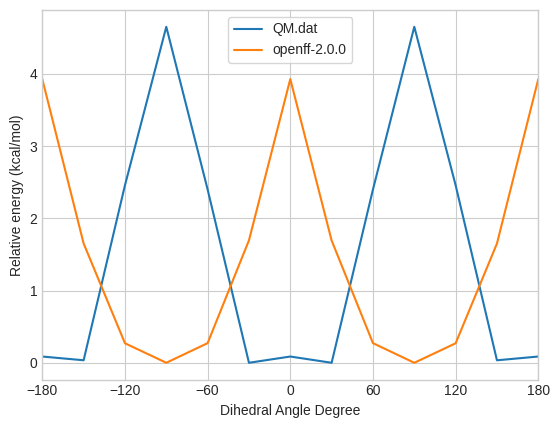

In [ ]:
#@title **Visualize the Energy Profile Calculated with OpenMM**

#@markdown This plot shows the energy profile obtained using OpenMM.

#@markdown The **y-axis** represents the **relative energy** in *kcal/mol*, and the **x-axis** corresponds to the **dihedral angle** in degrees.

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

plt.plot(dihe_degree, relative, linewidth = 1.5, label = "QM.dat")
plt.plot(dihe_degree, energy_diff, linewidth = 1.5, label = Force_field)
plt.xticks(np.arange(min(dihe_degree), max(dihe_degree)+1, 60.0))
plt.xlim([-180, 180])
plt.legend(frameon=True)
plt.xlabel('Dihedral Angle Degree')
plt.ylabel('Relative energy (kcal/mol)')
plt.savefig("qm_mm.png", dpi=600, bbox_inches='tight')

In [ ]:
#@title **Optimize Dihedral Parameters Based on Reference Energy Profile**

#@markdown This step fits an empirical energy profile to a reference profile (e.g., from Psi4).
#@markdown We use a Python implementation of the [Rotational Profiler](https://rotprof.lncc.br/index.php) (Rusu *et al.*), which provides an analytical algorithm for computing classical torsional parameters. The fitting uses a **linear least-squares regression** method to determine optimal parameters.

#@markdown The generated dihedral profiles are compatible with standard functional forms used in popular biomolecular force fields such as **GROMOS**, **AMBER**, **OPLS**, and **CHARMM**.

#@markdown Users can select the preferred fitting function to best reproduce the reference conformational energy landscape. Notably, **Rotational Profiler does not constrain the phase shift (δ) to 0° or 180°**, allowing for **asymmetric δ values**. While this improves the fit accuracy, it may reduce parameter transferability across stereoisomers.

import argparse
import logging
import os
import numpy as np

# dihe_degree_360 = [d + 180 for d in dihe_degree]


with open("mm_rotprof.dat", "w") as a_file:
    for deg, row in zip(dihe_degree, energy_mm):
        # Formatting the output string
        line = f"{deg:.3f} {row[0]:.3f}\n"

        # Writing the formatted string to the file
        a_file.write(line)

with open("qm_rotprof.dat", "w") as a_file:
    for deg, row in zip(dihe_degree, relative):
        # Formatting the output string
        line = f"{deg:.3f} {row:.3f}\n"

        # Writing the formatted string to the file
        a_file.write(line)

import argparse
import logging
import os
import numpy as np

# FileLogger class
class FileLogger:
    def __init__(self, file_name, mode='a'):
        self.file_name = file_name
        self.logger = logging.getLogger(__name__)
        self.set_up_file_logger(mode)

    def set_up_file_logger(self, mode):
        file_handler = logging.FileHandler(self.file_name, mode=mode)
        formatter = logging.Formatter('[%(levelname)s] %(message)s')
        file_handler.setFormatter(formatter)
        self.logger.addHandler(file_handler)

    def set_level(self, level):
        self.logger.setLevel(level)

    def debug(self, message, *args):
        self.logger.debug(message, *args)

    def info(self, message, *args):
        self.logger.info(message, *args)

    def warning(self, message, *args):
        self.logger.warning(message, *args)

    def error(self, message, *args):
        self.logger.error(message, *args)


# DataFileReader class
class DataFileReader:
    def __init__(self, file_name):
        self.file_name = file_name
        self.logger = logging.getLogger(__name__)

    def read_file(self):
        phis = []
        enes = []
        try:
            with open(self.file_name, 'r') as file:
                for line in file:
                    if line.startswith('#') or not line.strip():
                        continue  # Skip commented or empty lines
                    parts = line.split()
                    if len(parts) >= 2:
                        try:
                            phi = float(parts[0])
                            ene = float(parts[1])
                            phis.append(phi)
                            enes.append(ene)
                            self.logger.debug("data line: %s", line.strip())
                        except ValueError as e:
                            self.logger.error("Invalid data format: %s", e)
            if len(phis) == 0:
                self.logger.error("No data found inside data file %s", self.file_name)
                return [], []
            return phis, enes
        except IOError as e:
            self.logger.error("Error reading file %s: %s", self.file_name, e)
            return [], []

# IniFileReader class
class IniFileReader:
    def __init__(self, file_name):
        self.file_name = file_name
        self.logger = logging.getLogger(__name__)

    def read_file(self, N):
        is_active = [0] * N
        pshift = [0] * N
        multiplicities = [0] * N
        phase_offsets = [0.0] * N

        try:
            with open(self.file_name, 'r') as file:
                nlines = 0
                for line in file:
                    if line.startswith('#') or not line.strip():
                        continue  # Skip commented or empty lines
                    parts = line.split()
                    if len(parts) >= 4:
                        try:
                            multi = int(parts[0])
                            phi_shift = int(parts[1])
                            phase_offset = float(parts[2])
                            active = int(parts[3])

                            if nlines < N:
                                multiplicities[nlines] = multi
                                pshift[nlines] = phi_shift
                                phase_offsets[nlines] = phase_offset
                                is_active[nlines] = active
                                nlines += 1
                            else:
                                break  # Stop reading if N lines are read

                            self.logger.debug("ini line: %s", line.strip())
                        except ValueError as e:
                            self.logger.error("Invalid data format: %s", e)
            if nlines != N:
                self.logger.error(f"Expected {N} lines in file, found {nlines}")
                return [], [], [], []

            num_active_coeffs = sum(is_active)
            if num_active_coeffs < 1:
                self.logger.error("There are no active coefficients")
                return [], [], [], []

            return multiplicities, pshift, phase_offsets, is_active
        except IOError as e:
            self.logger.error("Error reading file %s: %s", self.file_name, e)
            return [], [], [], []


pi = 3.1415926535897932384626433832795028841971693993751058209749445923078164062862089986280348253421170679
SMALL_REAL = 1.0E-8

def m_prod(a, b, ndim):
    c = np.zeros((ndim, ndim))
    a = a.reshape(ndim, ndim)
    b = b.reshape(ndim, ndim)
    for i in range(ndim):
        for j in range(ndim):
            sum = 0.0
            for k in range(ndim):
                sum += a[k, i] * b[j, k]
            c[j, i] = sum
    return c.ravel()

def mv_prod(a, u, ndim):
    v = np.zeros(ndim)
    for i in range(ndim):
        sum = 0.0
        for j in range(ndim):
            sum += a[j * ndim + i] * u[j]
        v[i] = sum
    return v

def m_gjpdiag(a, ndim):
    d = 1.0
    l = np.zeros(ndim, dtype=int)
    m = np.zeros(ndim, dtype=int)

    for k in range(ndim):
        l[k] = m[k] = k
        biga = a[k * ndim + k]

        # Search for largest element
        for j in range(k, ndim):
            for i in range(k, ndim):
                hold = a[ndim * j + i]
                if abs(biga) < abs(hold):
                    biga = hold
                    l[k] = i
                    m[k] = j

        # Interchange rows
        if l[k] > k:
            for i in range(ndim):
                hold = -a[k * ndim + i]
                a[k * ndim + i] = a[l[k] * ndim + i]
                a[l[k] * ndim + i] = hold

        # Interchange columns
        if m[k] > k:
            for i in range(ndim):
                hold = -a[i * ndim + k]
                a[i * ndim + k] = a[i * ndim + m[k]]
                a[i * ndim + m[k]] = hold

        # Divide column by minus pivot
        if biga > -SMALL_REAL and biga < SMALL_REAL:
            return a, 0.0  # Matrix is singular

        for i in range(ndim):
            if i != k:
                a[i * ndim + k] /= -biga

        # Reduce matrix
        for i in range(ndim):
            if i != k:
                for j in range(ndim):
                    if j != k:
                        a[i * ndim + j] += a[i * ndim + k] * a[k * ndim + j]

        # Divide row by pivot
        for j in range(ndim):
            if j != k:
                a[k * ndim + j] /= biga

        # Product of pivots
        d *= biga

        # Replace pivot by reciprocal
        a[k * ndim + k] = 1.0 / biga

    # Final row and column interchange
    for k in range(ndim - 2, -1, -1):
        if l[k] != k:
            for j in range(ndim):
                hold = a[j * ndim + k]
                a[j * ndim + k] = -a[j * ndim + l[k]]
                a[j * ndim + l[k]] = hold

        if m[k] != k:
            for i in range(ndim):
                hold = a[k * ndim + i]
                a[k * ndim + i] = -a[m[k] * ndim + i]
                a[m[k] * ndim + i] = hold

    return a, d

def fit_dihedral(num_active_coeffs, phis, ref_energies, mm_energies, weights, mult, pshift, phase_offset, is_active):
    nPTS = len(phis)
    N = len(is_active)
    a = np.zeros((N * N))
    atmp = np.zeros((N * N))
    atmp2 = np.zeros((N * N))
    b = np.zeros(N)
    c = np.zeros(N)
    cmod = np.zeros(N)
    fittedcurve = np.zeros(nPTS)
    fittedcoeff = np.zeros(N)
    lwrk = np.zeros(N, dtype=int)
    mwrk = np.zeros(N, dtype=int)

    i = 0
    for k in range(N):
        if is_active[k]:
            i += 1
            j = 0
            for l in range(N):
                if is_active[l]:
                    j += 1
                    sum = 0.0
                    for m in range(nPTS):
                        ph1 = (phis[m] - phase_offset[k]) / 360.0 * 2.0 * pi
                        ph2 = (phis[m] - phase_offset[l]) / 360.0 * 2.0 * pi
                        sum += weights[m] * (1.0 + pshift[k] * np.cos(mult[k] * ph1)) * \
                               (1.0 + pshift[l] * np.cos(mult[l] * ph2))
                    a[num_active_coeffs * (i - 1) + (j - 1)] = sum

            sum = 0.0
            for m in range(nPTS):
                ph = (phis[m] - phase_offset[k]) / 360.0 * 2.0 * pi
                sum += weights[m] * (1.0 + pshift[k] * np.cos(mult[k] * ph)) * (ref_energies[m] - mm_energies[m])
            b[i - 1] = sum

    for i in range(num_active_coeffs):
        for j in range(num_active_coeffs):
            atmp[N * i + j] = a[num_active_coeffs * i + j]

    # a, det = m_gjpdiag(a, num_active_coeffs)
    # if det == 0.0:
    #     print("Matrix inversion error, det = 0")
    #     return None, None

    a, det = m_gjpdiag(a, num_active_coeffs)
    # if det == 0.0:
    #     print("Warning: Singular matrix encountered. Using pseudo-inverse.")
    #     coeffs = np.dot(np.linalg.pinv(a.reshape(num_active_coeffs, num_active_coeffs)), b)
    # else:
    atmp2 = m_prod(atmp, a, num_active_coeffs)
    coeffs = mv_prod(a, b, num_active_coeffs)
    atmp2 = m_prod(atmp, a, num_active_coeffs)
    c = mv_prod(a, b, num_active_coeffs)
    cmod = mv_prod(a, b, num_active_coeffs)

    for m in range(num_active_coeffs):
        fittedcoeff[m] = c[m]

    for m in range(nPTS):
        sum1 = 0.0
        sum2 = 0.0
        i = 0
        for k in range(N):
            if is_active[k]:
                i += 1
                ph = (phis[m] - phase_offset[k]) / 360.0 * 2.0 * pi
                sum1 += c[i - 1] * (1.0 + pshift[k] * np.cos(mult[k] * ph))
                sum2 += cmod[i - 1] * (1.0 + pshift[k] * np.cos(mult[k] * ph))
        fittedcurve[m] = mm_energies[m] + sum1

    return fittedcurve, fittedcoeff

# Function to create directories
def create_dir(path):
    """Create a directory if it does not exist."""
    try:
        os.makedirs(path, exist_ok=True)
        return True
    except OSError as e:
        if e.errno != errno.EEXIST:
            print(f"Error creating directory {path}: {e}")
            return False
        return True  # Directory already exists

def calculate_rmse(predicted, actual):
    return np.sqrt(np.mean((predicted - actual) ** 2))

# Setting parameters directly (these would typically be command line arguments)
basedir = './'  # Directory to save the output files
logfile_name = os.path.join(basedir, 'output.log')  # Output filename
# ini_filename = 'inifile2.dat'  # Configuration file
ref_filename = 'qm_rotprof.dat'  # File with reference profile
mm_filename = 'mm_rotprof.dat'  # File with MM profile

# Define your parameters here
mult = [0, 1, 1, 2, 2, 3, 6]
pshift = [1, 1, 1, 1, 1, 1, 1]
phase_offsets = [0, 0, 120, 0, 120, 0, 0]
is_active = [1, 1, 1, 1, 1, 1, 1]  # Activate coefficients

run_sequences = [
    [3],
    [0, 3],
    [0, 3, 5],
    [0, 3, 5, 6],
    [0, 1, 3, 5, 6],
    [0, 1, 2, 3, 5, 6],
    [0, 1, 2, 3, 4, 5, 6]
]


# Setup logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# FileLogger setup and directory creation
if not create_dir(basedir):
    logger.error("Unable to create directory %s", basedir)

file_logger = FileLogger(logfile_name)
file_logger.set_level(logging.INFO)

# Process INI file
# ini_reader = IniFileReader(ini_filename)
# mult, pshift, phase_offsets, is_active = ini_reader.read_file(NUM_BAS_FCT)

# Calculate the number of active coefficients
num_active_coeffs = sum(is_active)

# Process reference file
ref_reader = DataFileReader(ref_filename)
ref_phis, ref_energies = ref_reader.read_file()

# Process MM file
mm_reader = DataFileReader(mm_filename)
mm_phis, mm_energies = mm_reader.read_file()

# Additional checks and computations
if len(ref_phis) != len(mm_phis):
    logger.error("Number of reference and MM points are not the same")
    # Handle the error as needed

# Adjust reference and MM energy profiles
minimum_ref_value = min(ref_energies)
minimum_mm_value = min(mm_energies)

if abs(minimum_ref_value) > SMALL_REAL:
    ref_energies = [ene - minimum_ref_value for ene in ref_energies]

if abs(minimum_mm_value) > SMALL_REAL:
    mm_energies = [ene - minimum_mm_value for ene in mm_energies]

# Fitting process
weights = [1.0] * len(ref_phis)  # Assuming equal weights for simplicity

fitted_curves = []
multiplicity_list = []
phase_offset_list = []
fitted_coefficients_list = []

for run_index, sequence in enumerate(run_sequences, start=1):
    # Select elements based on the current sequence
    selected_mult = [mult[i] for i in sequence]
    selected_pshift = [pshift[i] for i in sequence]
    selected_phase_offset = [phase_offsets[i] for i in sequence]
    selected_is_active = [1] * len(sequence)  # Activate all selected elements

    NCOEF = sum(selected_is_active)
    NUM_BAS_FCT = sum(selected_is_active)
    SMALL_REAL = 1.0E-8
    N = sum(selected_is_active)

    # Run the fitting function
    fitted_curve, fitted_coeff = fit_dihedral(
        len(sequence),
        ref_phis,
        ref_energies,
        mm_energies,
        weights,
        selected_mult,
        selected_pshift,
        selected_phase_offset,
        selected_is_active
    )
    fitted_curves.append(fitted_curve)

    # Write header line
    print("Multiplicity\tOffset\tCoefficient")

    # Write data
    for mult1, offset, coeff in zip(selected_mult, selected_phase_offset, fitted_coeff):
        print(f"{mult1}\t{offset}\t{coeff}")

    rmse = calculate_rmse(fitted_curve, ref_energies)
    print(f"RMSE for fitted curve {run_index}: {rmse}\n")

    # Save fitted_curve and fitted_coeff to files
    curve_file_name = f"fitted_curve_{run_index}.dat"
    coeff_file_name = f"fitted_coefficients_{run_index}.dat"

    # Save fitted curve
    with open(curve_file_name, 'w') as f_curve:
        for phi, energy in zip(ref_phis, fitted_curve):  # Assuming first fitted curve
            f_curve.write(f"{phi} {energy}\n")

    # Save fitted coefficients
    with open(coeff_file_name, 'w') as f_coeff:
        # Write header line
        f_coeff.write("Multiplicity\tOffset\tCoefficient\n")

        # Write data
        for mult1, offset, coeff in zip(selected_mult, selected_phase_offset, fitted_coeff):
            multiplicity_list.append(mult1)
            phase_offset_list.append(offset)
            fitted_coefficients_list.append(coeff)
            f_coeff.write(f"{mult1}\t{offset}\t{coeff}\n")


Multiplicity	Offset	Coefficient
2	0	-1.3032045454545453
RMSE for fitted curve 1: 2.4779595371307703

Multiplicity	Offset	Coefficient
0	0	2.2041388888888886
2	0	-4.108472222222221
RMSE for fitted curve 2: 0.1582123120485907

Multiplicity	Offset	Coefficient
0	0	2.192112745098039
2	0	-4.105465686274509
3	0	0.022549019607842613
RMSE for fitted curve 3: 0.15736954244194182

Multiplicity	Offset	Coefficient
0	0	2.265041666666667
2	0	-4.089259259259259
3	0	0.006342592592591956
6	0	-0.13775462962962948
RMSE for fitted curve 4: 0.07885533474447867

Multiplicity	Offset	Coefficient
0	0	2.285755045318994
1	0	-0.04142675730465512
2	0	-4.09386223229311
3	0	0.010945565626442479
6	0	-0.14005611614655467
RMSE for fitted curve 5: 0.07306212047315391

Multiplicity	Offset	Coefficient
0	0	2.2852885389680484
1	0	-0.04111575307069143
1	120	0.0006220084679273519
2	0	-4.09386223229311
3	0	0.010945565626442479
6	0	-0.14005611614655467
RMSE for fitted curve 6: 0.07306120395259452

Multiplicity	Offset	Coefficient


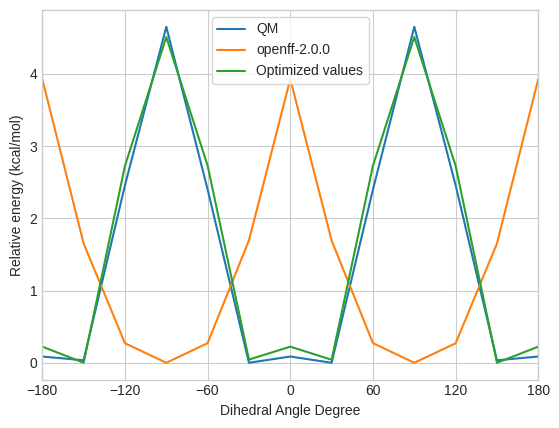

In [ ]:
#@title **Visualize the Optimized Dihedral Profile**

#@markdown The optimized parameters printed in the previous cell are those that should be added to your force field to correctly parametrize the selected dihedral.

#@markdown Please select the number of Fourier terms (periodic functions) you want to include in your topology definition.

PK_IDIVF1 = fitted_coefficients_list[0]
PK_IDIVF2 = fitted_coefficients_list[1:3]
PK_IDIVF3 = fitted_coefficients_list[3:6]
PK_IDIVF4 = fitted_coefficients_list[6:10]
PK_IDIVF5 = fitted_coefficients_list[10:15]
PK_IDIVF6 = fitted_coefficients_list[15:21]
PK_IDIVF7 = fitted_coefficients_list[21:28]

PHASE1 = phase_offset_list[0]
PHASE2 = phase_offset_list[1:3]
PHASE3 = phase_offset_list[3:6]
PHASE4 = phase_offset_list[6:10]
PHASE5 = phase_offset_list[10:15]
PHASE6 = phase_offset_list[15:21]
PHASE7 = phase_offset_list[21:28]

PN1 = multiplicity_list[0]
PN2 = multiplicity_list[1:3]
PN3 = multiplicity_list[3:6]
PN4 = multiplicity_list[6:10]
PN5 = multiplicity_list[10:15]
PN6 = multiplicity_list[15:21]
PN7 = multiplicity_list[21:28]

functions = "2" #@param ["1", "2", "3", "4", "5", "6", "7"]

mm_file = "mm.dat"
mm = list(map(float, open(mm_file).read().split()))
angles = range(-180, (180 + int(degrees_steps)), int(degrees_steps))
values = []

if functions == "1":
    dict_params = {0: [PK_IDIVF1, PHASE1, PN1]}
    for i, ANGLE in enumerate(angles):
        EDIHEDRAL1 = PK_IDIVF1 * (1 + math.cos(math.radians(PN1 * ANGLE - PHASE1)))
        values.append(EDIHEDRAL1 + mm[i])

elif functions == "2":
    dict_params = {1: [PK_IDIVF2[1], PHASE2[1], PN2[1]]}
    for i, ANGLE in enumerate(angles):
        EDIHEDRAL2 = PK_IDIVF2[1] * (1 + math.cos(math.radians(PN2[1] * ANGLE - PHASE2[1])))
        values.append(EDIHEDRAL2 + mm[i])

elif functions == "3":
    dict_params = {1: [PK_IDIVF3[1], PHASE3[1], PN3[1]], 2: [PK_IDIVF3[2], PHASE3[2], PN3[2]]}
    for i, ANGLE in enumerate(angles):
        EDIHEDRAL2 = PK_IDIVF3[1] * (1 + math.cos(math.radians(PN3[1] * ANGLE - PHASE3[1])))
        EDIHEDRAL3 = PK_IDIVF3[2] * (1 + math.cos(math.radians(PN3[2] * ANGLE - PHASE3[2])))
        values.append(EDIHEDRAL2 + EDIHEDRAL3 + mm[i])

elif functions == "4":
    dict_params = {1: [PK_IDIVF4[1], PHASE4[1], PN4[1]], 2: [PK_IDIVF4[2], PHASE4[2], PN4[2]], 3: [PK_IDIVF4[3], PHASE4[3], PN4[3]]}
    for i, ANGLE in enumerate(angles):
        EDIHEDRAL2 = PK_IDIVF4[1] * (1 + math.cos(math.radians(PN4[1] * ANGLE - PHASE4[1])))
        EDIHEDRAL3 = PK_IDIVF4[2] * (1 + math.cos(math.radians(PN4[2] * ANGLE - PHASE4[2])))
        EDIHEDRAL4 = PK_IDIVF4[3] * (1 + math.cos(math.radians(PN4[3] * ANGLE - PHASE4[3])))
        values.append(EDIHEDRAL2 + EDIHEDRAL3 + EDIHEDRAL4 + mm[i])

elif functions == "5":
    dict_params = {1: [PK_IDIVF5[1], PHASE5[1], PN5[1]], 2: [PK_IDIVF5[2], PHASE5[2], PN5[2]], 3: [PK_IDIVF5[3], PHASE5[3], PN5[3]], 4: [PK_IDIVF5[4], PHASE5[4], PN5[4]]}
    for i, ANGLE in enumerate(angles):
        EDIHEDRAL2 = PK_IDIVF5[1] * (1 + math.cos(math.radians(PN5[1] * ANGLE - PHASE5[1])))
        EDIHEDRAL3 = PK_IDIVF5[2] * (1 + math.cos(math.radians(PN5[2] * ANGLE - PHASE5[2])))
        EDIHEDRAL4 = PK_IDIVF5[3] * (1 + math.cos(math.radians(PN5[3] * ANGLE - PHASE5[3])))
        EDIHEDRAL5 = PK_IDIVF5[4] * (1 + math.cos(math.radians(PN5[4] * ANGLE - PHASE5[4])))
        values.append(EDIHEDRAL2 + EDIHEDRAL3 + EDIHEDRAL4 + EDIHEDRAL5 + mm[i])

elif functions == "6":
    dict_params = {1: [PK_IDIVF6[1], PHASE6[1], PN6[1]], 2: [PK_IDIVF6[2], PHASE6[2], PN6[2]], 3: [PK_IDIVF6[3], PHASE6[3], PN6[3]], 4: [PK_IDIVF6[4], PHASE6[4], PN6[4]], 5: [PK_IDIVF6[5], PHASE6[5], PN6[5]]}
    for i, ANGLE in enumerate(angles):
        EDIHEDRAL2 = PK_IDIVF6[1] * (1 + math.cos(math.radians(PN6[1] * ANGLE - PHASE6[1])))
        EDIHEDRAL3 = PK_IDIVF6[2] * (1 + math.cos(math.radians(PN6[2] * ANGLE - PHASE6[2])))
        EDIHEDRAL4 = PK_IDIVF6[3] * (1 + math.cos(math.radians(PN6[3] * ANGLE - PHASE6[3])))
        EDIHEDRAL5 = PK_IDIVF6[4] * (1 + math.cos(math.radians(PN6[4] * ANGLE - PHASE6[4])))
        EDIHEDRAL6 = PK_IDIVF6[5] * (1 + math.cos(math.radians(PN6[5] * ANGLE - PHASE6[5])))
        values.append(EDIHEDRAL2 + EDIHEDRAL3 + EDIHEDRAL4 + EDIHEDRAL5 + EDIHEDRAL6 + mm[i])

elif functions == "7":
    dict_params = {1: [PK_IDIVF7[1], PHASE7[1], PN7[1]], 2: [PK_IDIVF7[2], PHASE7[2], PN7[2]], 3: [PK_IDIVF7[3], PHASE7[3], PN7[3]], 4: [PK_IDIVF7[4], PHASE7[4], PN7[4]], 5: [PK_IDIVF7[5], PHASE7[5], PN7[5]], 6: [PK_IDIVF7[6], PHASE7[6], PN7[6]]}
    for i, ANGLE in enumerate(angles):
        EDIHEDRAL2 = PK_IDIVF7[1] * (1 + math.cos(math.radians(PN7[1] * ANGLE - PHASE7[1])))
        EDIHEDRAL3 = PK_IDIVF7[2] * (1 + math.cos(math.radians(PN7[2] * ANGLE - PHASE7[2])))
        EDIHEDRAL4 = PK_IDIVF7[3] * (1 + math.cos(math.radians(PN7[3] * ANGLE - PHASE7[3])))
        EDIHEDRAL5 = PK_IDIVF7[4] * (1 + math.cos(math.radians(PN7[4] * ANGLE - PHASE7[4])))
        EDIHEDRAL6 = PK_IDIVF7[5] * (1 + math.cos(math.radians(PN7[5] * ANGLE - PHASE7[5])))
        EDIHEDRAL7 = PK_IDIVF7[6] * (1 + math.cos(math.radians(PN7[6] * ANGLE - PHASE7[6])))
        values.append(EDIHEDRAL2 + EDIHEDRAL3 + EDIHEDRAL4 + EDIHEDRAL5 + EDIHEDRAL6 + EDIHEDRAL7+ mm[i])

values = np.array(values)
values = values - min(values)

#Plot ANI, MM and the new dihedral potential
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

plt.plot(dihe_degree, relative, linewidth = 1.5, label = "QM")
plt.plot(dihe_degree, energy_diff, linewidth = 1.5, label = Force_field)
plt.plot(dihe_degree, values, linewidth = 1.5, label = "Optimized values")
plt.xticks(np.arange(min(dihe_degree), max(dihe_degree)+1, 60.0))
plt.xlim([-180, 180])
plt.legend(frameon=True)
plt.xlabel('Dihedral Angle Degree')
plt.ylabel('Relative energy (kcal/mol)')
plt.savefig("qm_mm_fit.png", dpi=600, bbox_inches='tight')

In [ ]:
#@title **OpenMM Minimization with Optimized Dihedral Parameters**

#@markdown This step performs energy minimization using the newly optimized dihedral potential for the selected torsion.

#@markdown Force constant to restrain the dihedral angle:

Force_constant = 1000 #@param {type:"slider", min:100, max:2000, step:100}


#@markdown Convergence threshold for minimization energy:

opt_tol = 0.001 #@param {type:"slider", min:0.001, max:0.1, step:0.001}

from openmm import app, unit
from openmm.app import HBonds, NoCutoff, PDBFile
from openff.toolkit.topology import Molecule, Topology
from openff.toolkit.typing.engines.smirnoff import ForceField
from openff.toolkit.utils import get_data_file_path
from simtk.openmm.app import PDBFile

import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *
# import pytraj as pt
import xml.etree.ElementTree as ET
xml = openmm.XmlSerializer.serialize(system)
root = ET.fromstring(xml)

from sys import stdout, exit, stderr
import os, math, fnmatch

workDir2 = "/content/"

if os.path.exists(os.path.join(workDir2, "potential_energy_new.txt")):
  os.remove(os.path.join(workDir2,"potential_energy_new.txt"))
else:
  pass

# Create an OpenFF Molecule object for benzene from sdf
from openff.toolkit.topology import Molecule
molecule = Molecule.from_smiles(Smiles)
# molecule = Molecule.from_file("/content/mol_files/0_min.mol")

# Create an OpenMM ForceField object with AMBER ff14SB and TIP3P with compatible ions
from simtk.openmm.app import ForceField
forcefield = ForceField('amber99sb.xml')

# Register the  template generator
forcefield.registerTemplateGenerator(type_generator_options.generator)

potential_energy = []
dihe_degree = []
for deg in range(-180, (180+int(degrees_steps)), int(degrees_steps)):
  pdbfile = PDBFile(os.path.join(workDir, "mol_files/" + str(deg) + "_min.pdb"))
  system = forcefield.createSystem(pdbfile.topology, nonbondedCutoff=1*nanometer, constraints=HBonds)


  energy_expression = "k*(1-cos(periodicity*theta-theta0))"
  custom_torsion_force = CustomTorsionForce(energy_expression)
  custom_torsion_force.addGlobalParameter("k", int(Force_constant))
  custom_torsion_force.addGlobalParameter("periodicity", 1)
  custom_torsion_force.addGlobalParameter("theta0", math.radians(deg))
  custom_torsion_force.addTorsion(int(atom1), int(atom2), int(atom3), int(atom4))
  system.addForce(custom_torsion_force)

  dih = [f for f in system.getForces() if isinstance(f, PeriodicTorsionForce)][0]
  count = 0
  for k,v in dict_params.items():
    PK_IDIVF, PHASE, PN = v
    dih.addTorsion(int(atom1), int(atom2), int(atom3), int(atom4), PN, math.radians(PHASE)*radians, PK_IDIVF*kilojoules_per_mole*4.184)
    count += 1

  integrator = LangevinIntegrator(300*kelvin, 1/picosecond, 0.002*picoseconds)
  simulation = Simulation(pdbfile.topology, system, integrator)
  simulation.context.setPositions(pdbfile.positions)

  dih = [f for f in system.getForces() if isinstance(f, PeriodicTorsionForce)][0]
  for i in range(dih.getNumTorsions()):
    particle1, particle2, particle3, particle4, periodicity, phase, k = dih.getTorsionParameters(i)
    if particle2 == int(atom2) and particle3 == int(atom3):
      dih.setTorsionParameters(i, particle1, particle2, particle3, particle4, 1, 0, 0)
      dih.updateParametersInContext(simulation.context)
    elif particle2 == int(atom3) and particle3 == int(atom2):
      dih.setTorsionParameters(i, particle1, particle2, particle3, particle4, 1, 0, 0)
      dih.updateParametersInContext(simulation.context)

  dih = [f for f in system.getForces() if isinstance(f, PeriodicTorsionForce)][0]
  a = (dih.getNumTorsions() - 1) - count
  b = 0
  for k,v in dict_params.items():
    PK_IDIVF, PHASE, PN = v
    b += 1
    dih.setTorsionParameters(a+b, particle1, particle2, particle3, particle4, PN, math.radians(PHASE)*radians, PK_IDIVF*kilojoules_per_mole*4.184)
    dih.updateParametersInContext(simulation.context)

  dih = [f for f in system.getForces() if isinstance(f, PeriodicTorsionForce)][0]
  for i in range(dih.getNumTorsions()):
    particle1, particle2, particle3, particle4, periodicity, phase, k = dih.getTorsionParameters(i)
    # if particle2 == int(atom2) and particle3 == int(atom3):
    #   print(dih.getTorsionParameters(i))

  simulation.minimizeEnergy(tolerance=float(opt_tol)*kilojoule/(mole*nanometer), maxIterations=int(1000000))
  minpositions = simulation.context.getState(getPositions=True).getPositions()
  app.PDBFile.writeFile(pdbfile.topology, minpositions, open(os.path.join(workDir2, "pdb_min/" + str(deg) + '_min_new.pdb'), 'w'))

  energy_kcal =  (simulation.context.getState(getEnergy=True).getPotentialEnergy())
  potential_energy.append(energy_kcal)
  dihe_degree.append(deg)
  for i, f in enumerate(system.getForces()):
    state = simulation.context.getState(getEnergy=True, groups={i})
    # print(f.getName(), state.getPotentialEnergy())

  # print(str(deg) + " =", str(energy_kcal))
  print("Running minimization for step:" + str(deg))
  print(str(energy_kcal), file=open("potential_energy_new.txt", "a",))

#Prepare the relative energy from MM with new dihedral potential
import pandas as pd
dataset = pd.read_csv('/content/potential_energy_new.txt', delimiter = " ", header=None)
df = pd.DataFrame(dataset)
df = df[df.columns[:1]]
new = df.to_numpy()
energy_new = (np.array(new) - min(new)) * 0.239006

print("Degrees    Energy")
energy_mm_new = np.round(energy_new, 4)
a_file = open("mm_new.dat", "w")
for deg, row in zip(dihe_degree, energy_new):
    degree_str = str("{:.3f}".format(deg))
    energy_new_str = str("{:.3f}".format(row[0]))
    string = degree_str.rjust(8, " ") + energy_new_str.rjust(8, " ") + " kcal/mol"
    print(string)
    np.savetxt(a_file, row, fmt='%.6f')
a_file.close()

Running minimization for step:-180
Running minimization for step:-150
Running minimization for step:-120
Running minimization for step:-90
Running minimization for step:-60
Running minimization for step:-30
Running minimization for step:0
Running minimization for step:30
Running minimization for step:60
Running minimization for step:90
Running minimization for step:120
Running minimization for step:150
Running minimization for step:180
Degrees    Energy
-180.000   0.207 kcal/mol
-150.000   0.000 kcal/mol
-120.000   2.642 kcal/mol
 -90.000   4.495 kcal/mol
 -60.000   2.645 kcal/mol
 -30.000   0.045 kcal/mol
   0.000   0.207 kcal/mol
  30.000   0.045 kcal/mol
  60.000   2.645 kcal/mol
  90.000   4.495 kcal/mol
 120.000   2.644 kcal/mol
 150.000   0.000 kcal/mol
 180.000   0.207 kcal/mol


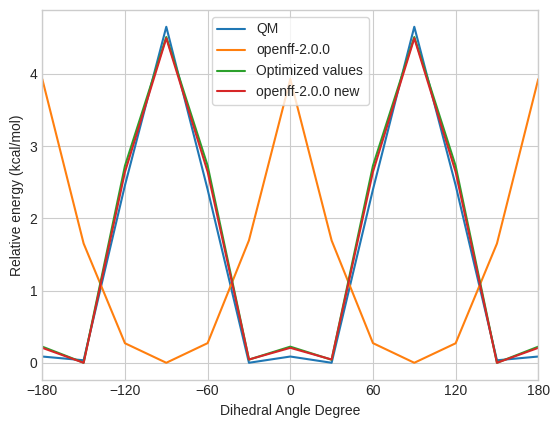

In [ ]:
#@title **Visualize the Energy Profile with Optimized Dihedral Parameters (OpenMM)**

#@markdown This plot displays the energy profile calculated using OpenMM with the newly optimized dihedral parameters.

#@markdown The **y-axis** shows the **relative energy** in *kcal/mol*, and the **x-axis** represents the dihedral angle in degrees.

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')


plt.plot(dihe_degree, relative, linewidth = 1.5, label = "QM")
plt.plot(dihe_degree, energy_diff, linewidth = 1.5, label = Force_field)
plt.plot(dihe_degree, values, linewidth = 1.5, label = "Optimized values")
plt.plot(dihe_degree, energy_new, linewidth = 1.5, label = str(Force_field) + " new")
plt.xticks(np.arange(min(dihe_degree), max(dihe_degree)+1, 60.0))
plt.xlim([-180, 180])
plt.legend(frameon=True)
plt.xlabel('Dihedral Angle Degree')
plt.ylabel('Relative energy (kcal/mol)')
plt.savefig("qm_mm_fit_new.png", dpi=600, bbox_inches='tight')

In [ ]:
#@title **Building the new topology**:

#@markdown Select the program of your choice:

program = "All" #@param ["All", "AMBER", "GROMACS", "OpenMM"]

from openff.toolkit.topology import Molecule, Topology
import parmed

topology = pdbfile.topology
# Create the Open Forcefield Topology.

omm_system = forcefield.createSystem(pdbfile.topology)
integrator = LangevinIntegrator(300*kelvin, 1/picosecond, 0.002*picoseconds)

# Convert OpenMM System to a ParmEd structure.

dih = [f for f in omm_system.getForces() if isinstance(f, PeriodicTorsionForce)][0]
count = 0
for k,v in dict_params.items():
  PK_IDIVF, PHASE, PN = v
  dih.addTorsion(int(atom1), int(atom2), int(atom3), int(atom4), PN, math.radians(PHASE)*radians, PK_IDIVF*kilojoules_per_mole*4.184)
  count = count + 1

simulation = Simulation(pdbfile.topology, omm_system, integrator)
simulation.context.setPositions(pdbfile.positions)

dih = [f for f in omm_system.getForces() if isinstance(f, PeriodicTorsionForce)][0]
for i in range(dih.getNumTorsions()):
  particle1, particle2, particle3, particle4, periodicity, phase, k = dih.getTorsionParameters(i)
  if particle2 == int(atom2) and particle3 == int(atom3):
    dih.setTorsionParameters(i, particle1, particle2, particle3, particle4, 0, 0, 0)
    dih.updateParametersInContext(simulation.context)
  elif particle2 == int(atom3) and particle3 == int(atom2):
    dih.setTorsionParameters(i, particle1, particle2, particle3, particle4, 0, 0, 0)
    dih.updateParametersInContext(simulation.context)

dih = [f for f in omm_system.getForces() if isinstance(f, PeriodicTorsionForce)][0]
a = (dih.getNumTorsions() - 1) - count
b = 0
for k,v in dict_params.items():
  PK_IDIVF, PHASE, PN = v
  b = b + 1
  dih.setTorsionParameters(a+b, particle1, particle2, particle3, particle4, PN, math.radians(PHASE)*radians, PK_IDIVF*kilojoules_per_mole*4.184)
  dih.updateParametersInContext(simulation.context)

parmed_structure = parmed.openmm.load_topology(pdbfile.topology, omm_system, pdbfile.positions)

if program == "AMBER":

  parmed_structure.save('system_amber.prmtop', overwrite=True)
  parmed_structure.save('system_amber.inpcrd', overwrite=True)
  parmed_structure.save('system_amber.pdb', overwrite=True)
  parmed_structure.save('system_amber.mol2', overwrite=True)

  amber_top = os.path.exists('system_amber.prmtop')
  amber_crd = os.path.exists('system_amber.inpcrd')
  amber_pdb = os.path.exists('system_amber.pdb')
  if amber_top == True and amber_crd == True and amber_pdb == True:
    print("Successfully generated topology! :-)")
  else:
    print("ERROR: Check your inputs! ")

elif program == "GROMACS":

  parmed_structure.save('system_gromacs.top', overwrite=True)
  parmed_structure.save('system_gromacs.gro', overwrite=True)
  parmed_structure.save('system_gromacs.pdb', overwrite=True)
  gromacs_top = os.path.exists('system_gromacs.top')
  gromacs_gro = os.path.exists('system_gromacs.gro')
  gromacs_pdb = os.path.exists('system_gromacs.pdb')
  if gromacs_top == True and gromacs_gro == True and gromacs_pdb == True:
    print("Successfully generated topology! :-)")
  else:
    print("ERROR: Check your inputs! ")

elif program == "OpenMM":

  parmed_structure.save('system_openMM.pdb', overwrite=True)
  with open('system_openMM.xml', 'w') as output:
    output.write(XmlSerializer.serialize(omm_system))
  openmm_pdb = os.path.exists('system_openMM.pdb')
  openmm_xml = os.path.exists('system_openMM.xml')
  if openmm_pdb == True and openmm_xml == True:
    print("Successfully generated topology! :-)")
  else:
    print("ERROR: Check your inputs! ")

else:

  parmed_structure.save('system_amber.prmtop', overwrite=True)
  parmed_structure.save('system_amber.inpcrd', overwrite=True)
  parmed_structure.save('system_amber.pdb', overwrite=True)

  parmed_structure.save('system_gromacs.top', overwrite=True)
  parmed_structure.save('system_gromacs.gro', overwrite=True)
  parmed_structure.save('system_gromacs.pdb', overwrite=True)

  parmed_structure.save('system_openMM.pdb', overwrite=True)
  with open('system_openMM.xml', 'w') as output:
    output.write(XmlSerializer.serialize(omm_system))

  amber_top = os.path.exists('system_amber.prmtop')
  amber_crd = os.path.exists('system_amber.inpcrd')
  amber_pdb = os.path.exists('system_amber.pdb')
  gromacs_top = os.path.exists('system_gromacs.top')
  gromacs_gro = os.path.exists('system_gromacs.gro')
  gromacs_pdb = os.path.exists('system_gromacs.pdb')
  openmm_pdb = os.path.exists('system_openMM.pdb')
  openmm_xml = os.path.exists('system_openMM.xml')
  if amber_top == True and amber_crd == True and amber_pdb == True and gromacs_top == True and gromacs_gro == True and gromacs_pdb == True and openmm_pdb == True and openmm_xml == True:
    print("Successfully generated topology! :-)")
  else:
    print("ERROR: Check your inputs! ")

Successfully generated topology! :-)


In [ ]:
#@title **Download your results**
from google.colab import files
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

if os.path.exists("dihedral_parameters.zip"):
  os.remove("dihedral_parameters.zip")
else:
  pass

!zip -FSr "dihedral_parameters.zip" "mol_files" "pdb_min" *".gro" *".pdb" *".top" *".prmtop" *".inpcrd" *".png" *."txt" *."dat" *."xml" *."svg"  >/dev/null 2>&1
files.download('dihedral_parameters.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>